# Figure 2

In this notebook, we will take a look at the performance of the RTRBM compared to the RBM on simulated data.

In [4]:
import os
import torch
import pandas as pd
from scipy.stats import spearmanr, mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt
from tqdm import tqdm

from zebrafish_rtrbm.models.RBM import RBM
from zebrafish_rtrbm.models.RTRBM import RTRBM

from zebrafish_rtrbm.utils.poisson_surrogate_data import PoissonTimeShiftedData
from zebrafish_rtrbm.utils.data_methods import create_U_hat
from zebrafish_rtrbm.utils.data_methods import reshape

plt.rcParams["font.family"] = "Arial"
plt.rcParams['ytick.labelsize']=7
plt.rcParams['xtick.labelsize']=7

path2dir = os.getcwd()

## Generate example of simulated data and plot some properties

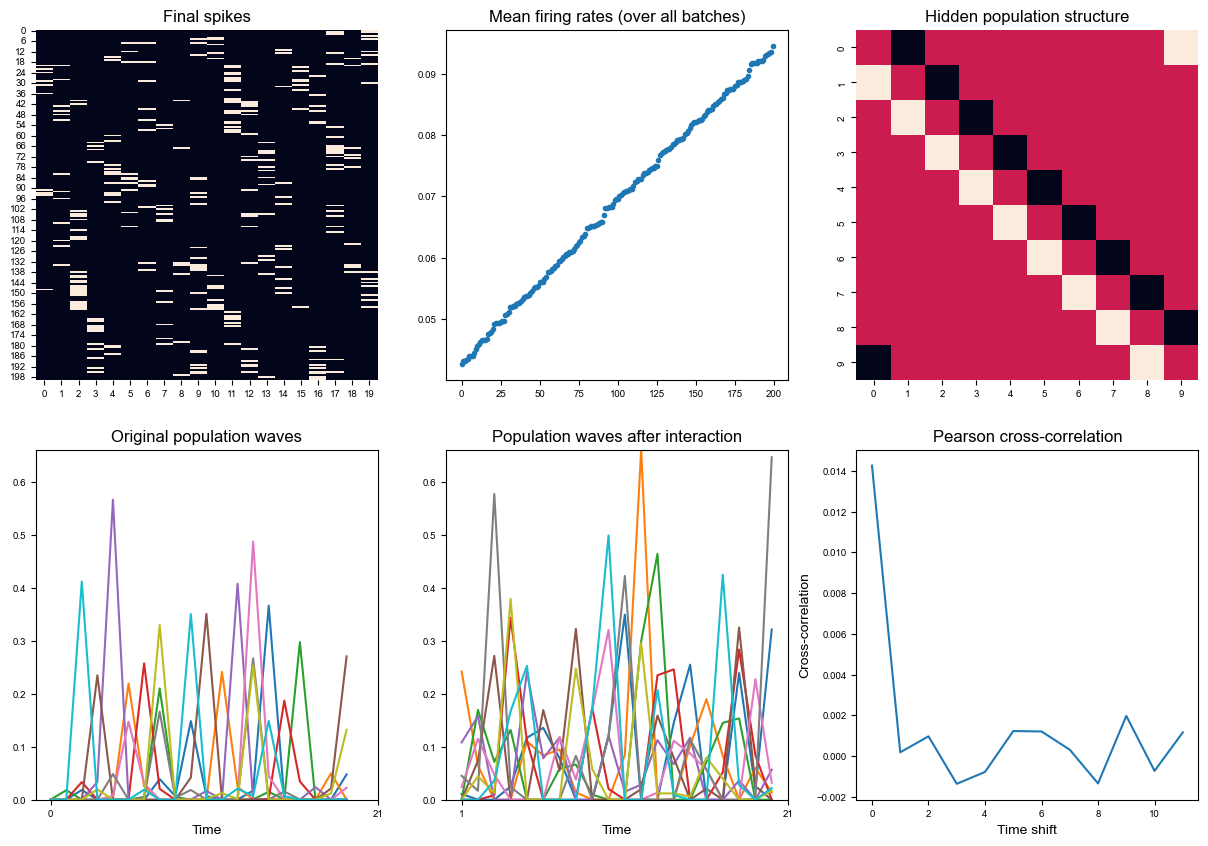

In [6]:
n_h = 10 # number of populations and hidden units
neurons_per_population = 20 # number of neurons per population
delay = 1 # population interaction delay

U_original = 0.7 * create_U_hat(n_h) # noticable but decaying connection. *1 = sustained feedback, >1 = positive feedback loop

int_range = [5, 10]  # interval range external input
max_fr = 0.6 # max firing rate of external input
std_range = [0.1, 0.5] # width of gaussian shaped peaks of external input

s = PoissonTimeShiftedData(
    neurons_per_population=neurons_per_population,
    n_populations=n_h, n_batches=500,
    time_steps_per_batch=100, steps_to_settle=25,
    delay=delay, U=U_original,
    int_range=int_range, max_fr=max_fr, 
    std_range=std_range, seed=1,
)

axes = s.plot_stats(T=20)
plt.show()

## Load data and rtrbm or re-create data and retrain rtrbm

In [7]:
data_dir = '../data/figure2_poisson'  # Directory path to save the model files to

In [8]:
n_runs = 10

n_h = 10 # number of populations and hidden units
neurons_per_population = 20 # number of neurons per population
delay = 1 # population interaction delay

U_original = 0.7 * create_U_hat(n_h) # noticable but decaying connection. *1 = sustained feedback, >1 = positive feedback loop

int_range = [5, 10]  # interval range external input
max_fr = 0.6 # max firing rate of external input
std_range = [0.1, 0.5] # width of gaussian shaped peaks of external input

In [47]:
train_list = []
test_list = []
rtrbm_list = []
rbm_list = []
for run in tqdm(range(1, n_runs+1)):

    run_dir = data_dir + '/run%s/'%(run)
    if not os.path.exists(run_dir):
        os.mkdir(run_dir)
     
    if not os.path.exists(run_dir + '/train'):
        
        s = PoissonTimeShiftedData(
        neurons_per_population=neurons_per_population,
        n_populations=n_h, n_batches=500,
        time_steps_per_batch=100, steps_to_settle=25,
        delay=delay, U=U_original,
        int_range=int_range, max_fr=max_fr, std_range=std_range,
        seed=run) # fixed seed per run

        data = reshape(reshape(s.data), T=20, n_batches=2500)
        train, test = data[..., :2000], data[..., 2000:] # shape [n_visible, time, n_batches]

        rtrbm = RTRBM(train, n_hidden=n_h, device=None)
        rtrbm.learn(batch_size=10, n_epochs=500, CDk=15, mom=0.9, wc=0.0002, disable_tqdm=False,
                    lr_schedule='geometric_decay', min_lr=5e-4, max_lr=1e-3)

        rbm = RBM(reshape(train), n_hidden=n_h, device=None)
        rbm.learn(batchsize=100, n_epochs=500, lr=1e-3, CDk=15, mom=0.9, wc=0.0002,
                  lr_schedule='geometric_decay', min_lr=5e-4, max_lr=1e-3)

        torch.save(train, run_dir + '/train')
        torch.save(test, run_dir + '/test')
        torch.save(rtrbm, run_dir + '/rtrbm')
        torch.save(rbm, run_dir + '/rbm')

        train_list += [train]
        test_list += [test]
        # rtrbm_list += [rtrbm]
        # rbm_list += [rbm]
       
    else:
        train_list += [torch.load(run_dir + '/train')]
        test_list += [torch.load(run_dir + '/test')]
        rtrbm_list += [torch.load(run_dir + '/rtrbm')]
        rbm_list += [torch.load(run_dir + '/rbm')]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.96it/s]


### Plot learned U-matrices for each run

In [36]:
# Choose which run to show below the models
run_show = 1 # one without sign adjustment needed
rtrbm, rbm = rtrbm_list[run_show], rbm_list[run_show]
train, test = train_list[run_show], test_list[run_show]

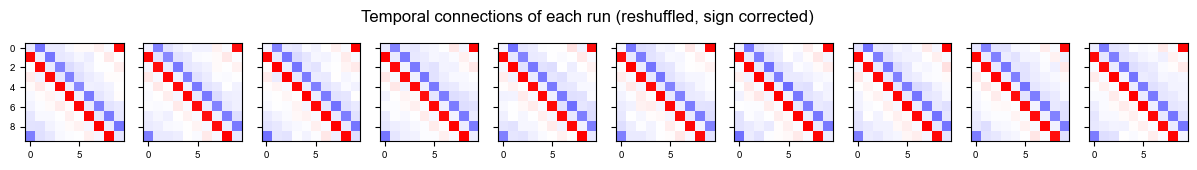

In [26]:
from zebrafish_rtrbm.utils.data_methods import shuffle_back

# Reshuffle (without duplicates), with sign correction
fig, axs = plt.subplots(1, 10, figsize=(15, 1.7), sharex=True, sharey=True)

W_hat = torch.zeros_like(rtrbm_list[0].W.cpu())
n_h, n_v = W_hat.shape
neurons_per_population = n_v // n_h 

for i in range(n_h):
    W_hat[i:(i+1), i*neurons_per_population:(i+1)*neurons_per_population] = 1

for i, (rtrbm, ax) in enumerate(zip(rtrbm_list, axs.flatten())):
    try:
        W_trained, U_trained = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat, allow_duplicates=False)
    except:
        continue
    # correct the U signs
    unit_signs = np.empty(n_h, dtype='int')
    
    for unit in range(n_h):
        # mean of population
        mean_weight = W_trained[unit:(unit+1), unit*neurons_per_population:(unit+1)*neurons_per_population].mean()
        
        unit_signs[unit] = np.sign(mean_weight)
    
    U_trained = U_trained * np.outer(unit_signs, unit_signs)
    
    # plot the result
    lim = float(np.abs(U_trained).max())
    
    ax.imshow(U_trained, cmap=plt.get_cmap('bwr'), vmin=-lim, vmax=lim)

    row = i // 10
    col = i % 10

fig.suptitle('Temporal connections of each run (reshuffled, sign corrected)')

plt.show()

## Compute data and model statistics

In [58]:
vs_rtrbm, hs_rtrbm = rtrbm.sample(torch.tensor(test[:, 0, :]).to(rtrbm.device), chain=test.shape[1], pre_gibbs_k=4000, gibbs_k=100, mode=2)
vs_rbm, _ = rbm.sample(torch.tensor(test[:, 0, :]).to(rbm.device), chain=test.shape[1], pre_gibbs_k=4000, gibbs_k=100, mode=2)
hs_rbm, _ = rbm.visible_to_hidden(vs_rbm.to(rbm.device))
ht_rtrbm = rtrbm._parallel_recurrent_sample_r_given_v(test.to(rtrbm.device))
ht_rbm, _ = rbm.visible_to_hidden(reshape(test).to(rbm.device))
vt = test.detach().clone()

W, U = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat)
W_rbm = shuffle_back(rbm.W.cpu(), U_trained=None, W_true=W_hat)

C:\Users\luukh\AppData\Local\Temp\ipykernel_3916\160763334.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs_rtrbm, hs_rtrbm = rtrbm.sample(torch.tensor(test[:, 0, :]).to(rtrbm.device), chain=test.shape[1], pre_gibbs_k=4000, gibbs_k=100, mode=2)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.68s/it]
C:\Users\luukh\AppData\Local\Temp\ipykernel_3916\160763334.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs_rbm, _ = rbm.sample(torch.tensor(test[:, 0, :]).to(rbm.device), chain=test.shape[1], pre_gibbs_k=4000, gibbs_k=100, mode=2)
100%|██████████████████████████████████████████████████████████████████████████████████

## Display weights of RBM and RTRBM

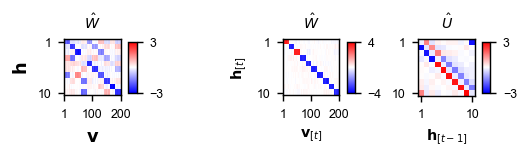

In [59]:
fig = plt.figure(constrained_layout=True, figsize=(4.46, 1.05), dpi=128)
gs = fig.add_gridspec(1, 10)
ax = fig.add_subplot(gs[0, 2:4])

cm = ax.imshow(W_rbm, aspect=neurons_per_population, cmap=plt.get_cmap('bwr'), vmin=-3, vmax=3, interpolation='none')
ax.set_title('$\hat{W}$', fontsize=8)
ax.set_xticks([0, 100, 200])
ax.set_xticklabels([1, 100, 200], fontsize=7)
ax.set_yticks([0, 9])
ax.set_yticklabels([1, 10], fontsize=7)
ax.set_ylabel('$\mathbf{h}$')
ax.set_xlabel('$\mathbf{v}$')
cb = fig.colorbar(cm, ax=ax, aspect=6, ticks=[-3, 3], pad=-0.05)
cb.ax.tick_params(labelsize=7)

ax = fig.add_subplot(gs[0, 6:8])
cm = ax.imshow(W, aspect=neurons_per_population, cmap=plt.get_cmap('bwr'), vmin=-4, vmax=4, interpolation='none')
ax.set_title('$\hat{W}$', fontsize=8)
ax.set_xticks([0, 100, 200])
ax.set_xticklabels([1, 100, 200], fontsize=7)
ax.set_yticks([0, 9])
ax.set_yticklabels([1, 10], fontsize=7)
ax.set_xlabel('$\mathbf{v}_{[t]}$', fontsize=8)
ax.set_ylabel('$\mathbf{h}_{[t]}$', fontsize=8)
cb = fig.colorbar(cm, ax=ax, aspect=6, ticks=[-4, 4], pad=-0.05)
cb.ax.tick_params(labelsize=7)

ax = fig.add_subplot(gs[0, 8:])
cm1 = ax.imshow(U, aspect='equal', cmap=plt.get_cmap('bwr'), vmin=-3, vmax=3, interpolation='none')
cb1 = fig.colorbar(cm1, ax=ax, shrink=1, aspect=6, ticks=[-3, 3])
cb1.ax.tick_params(labelsize=7)

ax.set_xticks([0, 9])
ax.set_xticklabels([1, 10], fontsize=7)
ax.set_yticks([0, 9])
ax.set_yticklabels([1, 10], fontsize=7)
ax.set_xlabel('$\mathbf{h}_{[t-1]}$', fontsize=8)
ax.set_title(r'$\hat{U}$', fontsize=8)
plt.show()

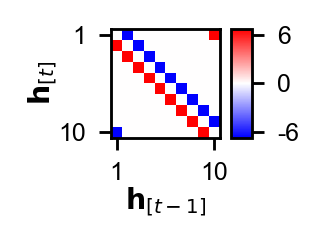

In [60]:
plt.figure(figsize = (1.1, 1.1), dpi=256, layout='constrained')
extent = [0.5, 10.5, 10.5, 0.5]

U_hat = create_U_hat(10) / 0.15

img = plt.imshow(U_hat, cmap='bwr', extent=extent)
plt.gca().set_xticks([1, 10], [1, 10], fontsize=7)
plt.gca().set_yticks([1, 10], [1, 10], fontsize=7)

plt.gca().set_xlabel('$\mathbf{h}_{[t-1]}$', fontsize=8, labelpad=0)
plt.gca().set_ylabel('$\mathbf{h}_{[t]}$', fontsize=8, labelpad=0)

cax = plt.gca().inset_axes([10.5 + 1, 0.5, 2, 10], transform=plt.gca().transData)
cbar = fig.colorbar(img, cax=cax)
cbar.ax.set_yticks([-6, 0, 6], [-6, 0, 6], fontsize=7)

plt.show()

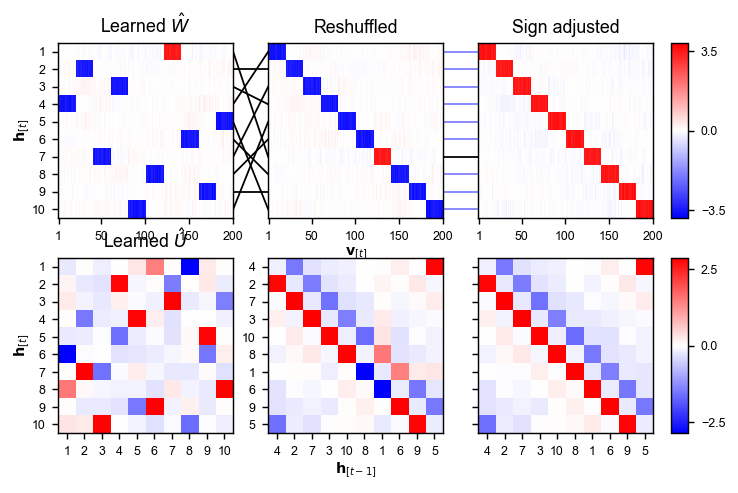

In [66]:
# Matrix alignment figure

def U_to_W(x):
    # Coordinates in U plot to W plot
    return neurons_per_population*(x + 0.5) - 0.5

# index -1 matches the one in the main figure,
# but this one shows a case where the W matrix is not all of the same sign,
# and sign adjustment is applied
rtrbm = rtrbm_list[6]

W = rtrbm.W.cpu()
U = rtrbm.U.cpu()

W_hat = torch.zeros_like(rtrbm_list[0].W.cpu())
for i in range(n_h):
    W_hat[i:(i+1), i*neurons_per_population:(i+1)*neurons_per_population] = 1

W_trained, U_trained = shuffle_back(W, U, W_true=W_hat, allow_duplicates = False)

# find shuffle (used for further analysis)
shuffle = np.empty(n_h, dtype='int')
for i in range(n_h):
    shuffle[i] = np.where(W[:, 0] == W_trained[i, 0])[0][0]

# Check if reshuffle is correct
# reshuffled_W = np.copy(W)
# reshuffled_W = reshuffled_W[shuffle, :]
# print(np.allclose(W_trained, reshuffled_W))


# correct the U signs
unit_signs = np.empty(n_h, dtype='int')

for unit in range(n_h):
    # mean of associated visible units
    mean_weight = W_trained[unit:(unit+1), unit*neurons_per_population:(unit+1)*neurons_per_population].mean()
    
    unit_signs[unit] = np.sign(mean_weight)

    
###############
# Plot result #
###############
    
fig, ax = plt.subplots(ncols=3, nrows=2, figsize = (6, 4), dpi=128)
W_lim = float(np.abs(W_trained).max())

# PLOT IMAGES
ax[0, 0].set_title(r"Learned $\hat{W}$", fontsize=10)
ax[0, 0].imshow(W, cmap='bwr', vmin=-W_lim, vmax=W_lim, aspect = neurons_per_population, interpolation = 'none')
 
ax[0, 1].set_title("Reshuffled", fontsize=10)
ax[0, 1].imshow(W_trained, cmap='bwr', vmin=-W_lim, vmax=W_lim, aspect = neurons_per_population, interpolation = 'none')
    
ax[0, 2].set_title("Sign adjusted", fontsize=10)
W_img = ax[0, 2].imshow(W_trained * unit_signs[:, np.newaxis], cmap='bwr', vmin=-W_lim, vmax=W_lim, aspect = neurons_per_population, interpolation = 'none')

U_lim = float(np.abs(U_trained).max())
ax[1, 0].set_title(r"Learned $\hat{U}$", fontsize=10)
ax[1, 0].imshow(U, cmap='bwr', vmin=-U_lim, vmax=U_lim)
ax[1, 1].imshow(U_trained, cmap='bwr', vmin=-U_lim, vmax=U_lim)
U_img = ax[1, 2].imshow(U_trained * np.outer(unit_signs, unit_signs), cmap='bwr', vmin=-U_lim, vmax=U_lim)

# SET TICKS
for i in range(3):
    ax[0, i].set_xticks([0, 50-1, 100-1, 150-1, 200-1], [1, 50, 100, 150, 200])

ax[0, 0].set_yticks(np.arange(10), np.arange(10)+1)
ax[0, 1].set_yticks([])
ax[0, 2].set_yticks([])

ax[1, 0].set_xticks(np.arange(10), np.arange(10)+1)
ax[1, 1].set_xticks(np.arange(10), shuffle+1)
ax[1, 2].set_xticks(np.arange(10), shuffle+1)

ax[1, 0].set_yticks(np.arange(10), np.arange(10)+1)
ax[1, 1].set_yticks(np.arange(10), shuffle+1)
ax[1, 2].set_yticks(np.arange(10), [])

# SHOW RESHUFFLING
for i in range(10):
    #ax[1, 0].plot([9.5, 11.5], [shuffle[i], i], c='k', clip_on=False, linewidth=1, zorder=-1)
    ax[0, 0].plot([U_to_W(9.5), U_to_W(11.5)], [shuffle[i], i], c='k', clip_on=False, linewidth=1, zorder=-1)
#ax[1, 0].set_xlim([-0.5, 9.5])
ax[0, 0].set_xlim([-0.5, U_to_W(9.5)])

# SHOW SIGN CORRECTION
for i in range(10):
    if unit_signs[shuffle[i]] == 1:
        c = 'k'
    else:
        c = (0.5, 0.5, 1.0)
    ax[0, 1].plot([U_to_W(9.5), U_to_W(11.5)], 2*[shuffle[i]], c=c, clip_on=False, linewidth=1, zorder=-1)
ax[0, 1].set_xlim([-0.5, U_to_W(9.5)])

# LABELS AND COLORBAR
ax[0, 1].set_xlabel('$\mathbf{v}_{[t]}$', fontsize=8, labelpad=2)
ax[0, 0].set_ylabel('$\mathbf{h}_{[t]}$', fontsize=8, labelpad=0)

ax[1, 1].set_xlabel('$\mathbf{h}_{[t-1]}$', fontsize=8, labelpad=2)
ax[1, 0].set_ylabel('$\mathbf{h}_{[t]}$', fontsize=8, labelpad=0)

cax = ax[1, 2].inset_axes([10.5, -0.5, 1, 10], transform=ax[1, 2].transData)
cbar = fig.colorbar(U_img, cax=cax)
cbar.ax.set_yticks([-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=7)

cax = ax[0, 2].inset_axes([U_to_W(10.5), -0.5, 1*neurons_per_population, 10], transform=ax[0, 2].transData)
cbar = fig.colorbar(W_img, cax=cax)
cbar.ax.set_yticks([-3.5, 0, 3.5])
cbar.ax.tick_params(labelsize=7)

#plt.savefig('images/figure2/fig2_matrix_alignment.svg')
plt.show()

## Compare model- with data- statistics

In [68]:
from zebrafish_rtrbm.utils.metrics import generate_moments

# get all first- and second order moments
vt, vvt, vvt_t, hht_rbm_t, hht_rtrbm_t, \
vs_rbm, vvs_rbm, vvs_rbm_t, hhs_rbm_t, \
vs_rtrbm, vvs_rtrbm, vvs_rtrbm_t, hhs_rtrbm_t = generate_moments(vt, vs_rbm, vs_rtrbm, ht_rbm, ht_rtrbm,
                                                                 hs_rbm, hs_rtrbm, n_neurons=20000)

In [69]:
def scatter_plt(x, y, ax=None, r=None, color='tab:blue'):
    if ax is None:
        fig, ax = plt.subplots()

    x, y = np.array(x), np.array(y)
    x[np.isnan(x)], y[np.isnan(y)]  = 0, 0
    ax.scatter(x, y, s=0.5, color=color)
    if r is None:
        r, pvalue = spearmanr(x, y)
    ax.text(.05, .9, '$r_s=%0.4s$'%r, transform=ax.transAxes, fontsize=5, fontweight='heavy')
    return ax

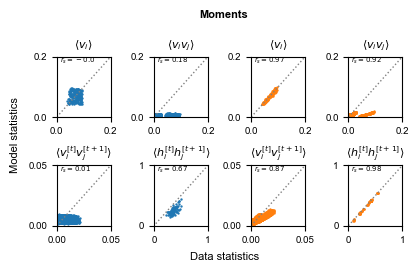

In [70]:
fig, axes = plt.subplots(2, 4, figsize=(4.46, 2.6))
fig.subplots_adjust(top=0.8, bottom=0.15, wspace=0.8, hspace=0.8)

ax = axes[0, 0]
ax = scatter_plt(torch.mean(vt, (1, 2)), torch.mean(vs_rbm, 1), ax=ax, color='tab:blue')
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .2])
ax.set_ylim([0, .2])
ax.set_xticks([0, .2])
ax.set_yticks([0, .2])
ax.set_title('$\langle v_i \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

ax = axes[0, 1]
ax = scatter_plt(vvt.flatten(), vvs_rbm.flatten(), ax=ax, color='tab:blue')
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .2])
ax.set_ylim([0, .2])
ax.set_xticks([0, .2])
ax.set_yticks([0, .2])
ax.set_title('$\langle v_iv_j \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

ax = axes[1, 0]
ax = scatter_plt(vvt_t.flatten(), vvs_rbm_t.flatten(), ax=ax, color='tab:blue')
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .05])
ax.set_ylim([0, .05])
ax.set_xticks([0, .05])
ax.set_yticks([0, .05])
ax.set_title('$\langle v_i^{[t]}v_j^{[t+1]} \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

ax = axes[1, 1]
ax = scatter_plt(hht_rbm_t.flatten(), hhs_rbm_t.flatten(), ax=ax, color='tab:blue')
ax.plot([-5, 5], [-5, 5], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_title('$\langle h_i^{[t]}h_j^{[t+1]} \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

ax=axes[0, 2]
ax = scatter_plt(torch.mean(vt, (1, 2)), torch.mean(vs_rtrbm, (1, 2)), ax=ax, color='tab:orange')
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .2])
ax.set_ylim([0, .2])
ax.set_xticks([0, .2])
ax.set_yticks([0, .2])
ax.set_title('$\langle v_i \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

ax = axes[0, 3]
ax = scatter_plt(vvt.flatten(), vvs_rtrbm.flatten(), ax=ax, color='tab:orange')
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, 0.2])
ax.set_ylim([0, 0.2])
ax.set_xticks([0, 0.2])
ax.set_yticks([0, 0.2])
ax.set_title('$\langle v_iv_j \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

ax = axes[1, 2]
ax = scatter_plt(vvt_t.flatten(), vvs_rtrbm_t.flatten(), ax=ax, color='tab:orange')
ax.plot([0, 1], [0, 1], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, .05])
ax.set_ylim([0, .05])
ax.set_xticks([0, .05])
ax.set_yticks([0, .05])
ax.set_title('$\langle v_i^{[t]}v_j^{[t+1]} \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

ax = axes[1, 3]
ax = scatter_plt(hht_rtrbm_t.flatten(), hhs_rtrbm_t.flatten(), ax=ax, color='tab:orange')
ax.plot([0, 2], [0, 2], 'grey', linestyle='dotted', linewidth=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_title('$\langle h_i^{[t]}h_j^{[t+1]} \\rangle$', fontsize=8)
ax.tick_params(labelsize=7)

fig.suptitle('Moments', fontsize=8, fontweight='bold')
fig.supxlabel('Data statistics', fontsize=8)
fig.supylabel('Model statistics', fontsize=8)

# plt.savefig(path2dir + '/figures/figure2_poisson/Moments_plot.png', dpi=1000)
plt.show()

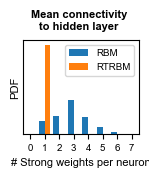

In [73]:
bins = np.arange(0, 10) - 0.5
bin_middles = bins[:-1] + np.diff(bins)/2
counts_rbm = np.zeros(len(bins)-1, dtype='int')
counts_rtrbm = np.zeros(len(bins)-1, dtype='int')

for i in range(10):
    av_conn_rtrbm = torch.sum(torch.abs(rtrbm_list[i].W.cpu()) > .5*torch.std(rtrbm_list[i].W.cpu()), 0)
    av_conn_rbm = torch.sum(torch.abs(rbm_list[i].W.cpu()) > .5*torch.std(rbm_list[i].W.cpu()), 0)

    counts_rbm += np.histogram(av_conn_rbm, bins=bins)[0]
    counts_rtrbm += np.histogram(av_conn_rtrbm, bins=bins)[0]
    

fig, ax = plt.subplots(figsize=(1.5, 1.7))
ax.bar(bin_middles - .2, counts_rbm / np.sum(counts_rbm), width=.4, label='RBM')
ax.bar(bin_middles + .2, counts_rtrbm / np.sum(counts_rtrbm), width=.4, label='RTRBM')

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7], fontsize=7)
ax.set_xlim([-.5, 7.5])
ax.set_ylabel('PDF', fontsize=8, labelpad=2)
#ax.set_ylabel('log(PDF)', fontsize=8)
#ax.set_yscale('log')
fig.suptitle('Mean connectivity\nto hidden layer', fontsize=8, fontweight='bold')
ax.set_xlabel('# Strong weights per neuron', fontsize=8)
ax.set_yticks([])
# ax.set_box_aspect()

fig.legend(fontsize=7, bbox_to_anchor=(0.9, .8))
# plt.tight_layout(pad=.2, h_pad=-0, w_pad=.2)
plt.subplots_adjust(bottom=0.25, top=0.8)
n_runs = 10

plt.show()

In [74]:
rmse_rbm, rv_rbm, rvv_rbm, rvt_rbm, rht_rbm, rmse_rtrbm, rv_rtrbm, rvv_rtrbm, rvt_rtrbm, rht_rtrbm = [torch.zeros(n_runs) for _ in range(10)]

for i, (train, test, rtrbm, rbm) in enumerate(zip(tqdm(train_list), test_list, rtrbm_list, rbm_list)):
    # generate data
    
    vs_rtrbm, hs_rtrbm = rtrbm.sample(torch.tensor(test[:, 0, :]).to(rtrbm.device), chain=test.shape[1], pre_gibbs_k=400, gibbs_k=100, disable_tqdm=True)
    vs_rbm, _ = rbm.sample(torch.tensor(test[:, 0, :]).to(rbm.device), chain=test.shape[1], pre_gibbs_k=400, gibbs_k=100, disable_tqdm=True)
    hs_rbm, _ = rbm.visible_to_hidden(vs_rbm.to(rbm.device))
    ht_rtrbm = rtrbm._parallel_recurrent_sample_r_given_v(test.to(rtrbm.device))
    ht_rbm, _ = rbm.visible_to_hidden(reshape(test).to(rbm.device))
    vt = test.detach().clone()


    # calculate moments
    vt, vvt, vvt_t, hht_rbm_t, hht_rtrbm_t, vs_rbm, vvs_rbm, vvs_rbm_t, hhs_rbm_t, vs_rtrbm, vvs_rtrbm, vvs_rtrbm_t, hhs_rtrbm_t = generate_moments(vt, vs_rbm, vs_rtrbm, ht_rbm, ht_rtrbm, hs_rbm, hs_rtrbm, n_neurons=200)

    # calculate correlations
    rv_rbm[i], _ = spearmanr(torch.mean(vt, (1, 2)), torch.mean(vs_rbm, 1))
    rvv_rbm[i], _ = spearmanr(vvs_rbm.flatten(), vvt.flatten())
    rvt_rbm[i], _ = spearmanr(vvs_rbm_t.flatten(), vvt_t.flatten())
    rht_rbm[i], _ = spearmanr(hhs_rbm_t.flatten(), hht_rbm_t.flatten())
    rv_rtrbm[i], _ = spearmanr(torch.mean(vs_rtrbm, (1, 2)), torch.mean(vt, (1, 2)))
    rvv_rtrbm[i], _ = spearmanr(vvs_rtrbm.flatten(), vvt.flatten())
    rvt_rtrbm[i], _ = spearmanr(vvs_rtrbm_t.flatten(), vvt_t.flatten())
    rht_rtrbm[i], _ = spearmanr(hhs_rtrbm_t.flatten(), hht_rtrbm_t.flatten())

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\luukh\AppData\Local\Temp\ipykernel_3916\2985562880.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs_rtrbm, hs_rtrbm = rtrbm.sample(torch.tensor(test[:, 0, :]).to(rtrbm.device), chain=test.shape[1], pre_gibbs_k=400, gibbs_k=100, disable_tqdm=True)
C:\Users\luukh\AppData\Local\Temp\ipykernel_3916\2985562880.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vs_rbm, _ = rbm.sample(torch.tensor(test[:, 0, :]).to(rbm.device), chain=test.shape[1], pre_gibbs_k=400, gibbs_k=100, disable_tqdm=True)
100%|█████████████████████████████████████████████████████████████

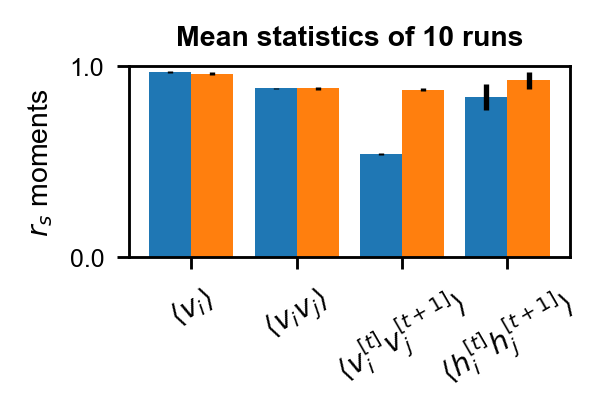

In [77]:
fig, axes = plt.subplots(figsize=(2.23, 1.5), dpi=256)

ax = axes
ax.bar(
    torch.arange(4) - .2,
    [torch.mean(rv_rbm), torch.mean(rvv_rbm), torch.mean(rvt_rbm), torch.mean(rht_rbm)],
    yerr=[torch.std(rv_rbm), torch.std(rvv_rbm), torch.std(rvt_rbm), torch.std(rht_rbm)],
    label='RBM',
    width=.4
)
ax.bar(
    torch.arange(4) + .2,
    [torch.mean(rv_rtrbm), torch.mean(rvv_rtrbm), torch.mean(rvt_rtrbm), torch.mean(rht_rtrbm)],
    yerr=[torch.std(rv_rtrbm), torch.std(rvv_rtrbm), torch.std(rvt_rtrbm), torch.std(rht_rtrbm)],
    label='RTRBM',
    width=.4
)

#ax.axhline(1, c='k', alpha=0.5, linestyle='--')

ax.set_ylim([0.0, 1.0])
ax.set_ylabel('$r_s$ moments', fontsize=8)
ax.set_xticks(torch.arange(4))
ax.set_xticklabels([r'$\langle v_i \rangle$', r'$\langle v_iv_j \rangle$', r'$\langle v_i^{[t]} v_j^{[t+1]} \rangle$', r'$\langle h_i^{[t]} h_j^{[t+1]} \rangle$'], fontsize=8, rotation=30)
ax.set_yticks([0.0, 1.0])
ax.set_yticklabels([0.0, 1.0], fontsize=7)

ax.set_title('Mean statistics of 10 runs', fontsize=8, fontweight='bold')
plt.tight_layout(pad=0.2, h_pad=0, w_pad=0.2)

# plt.savefig(path2dir + '/figures/figure2_poisson/Mean_stats_10_runs2.png', dpi=1000)
#plt.savefig(path2dir + '/images/Mean_stats_10_runs2.png', dpi=1000)
plt.show()

In [78]:
r, p = mannwhitneyu(rv_rbm, rv_rtrbm, alternative='less')
print('first order visible moments mann whitney u test: p = %.8f' %p)

r, p = mannwhitneyu(rvv_rbm, rvv_rtrbm, alternative='less')
print('second order visible moments mann whitney u test: p = %.8f' %p)

r, p = mannwhitneyu(rvt_rbm, rvt_rtrbm, alternative='less')
print('time shifted visible moments mann whitney u test: p = %.8f' %p)

r, p = mannwhitneyu(rht_rbm, rht_rtrbm, alternative='less')
print('time shifted hidden moments mann whitney u test: p = %.8f' %p)

first order visible moments mann whitney u test: p = 0.99889889
second order visible moments mann whitney u test: p = 0.26026144
time shifted visible moments mann whitney u test: p = 0.00009134
time shifted hidden moments mann whitney u test: p = 0.00229320


### Check generalisation error over time

In [53]:
%%time
def reshape_fortran(x, shape):
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))

# Generate own test data, for consistency
np.random.seed(1)
torch.random.manual_seed(1)

U_hat = create_U_hat(10) / 0.15

# create data
s_test = PoissonTimeShiftedData(
    neurons_per_population=neurons_per_population,
    n_populations=n_h, n_batches=1000,
    time_steps_per_batch=100 + 25, # 125 to match training data
    delay=delay, U=U_hat.T,
    int_range=int_range, fr_range=fr_range, std_range=std_range, seed=1)

# discard first few timesteps, as initial activity is different from long time activity

# Split into batches of size 20
_, timesteps_original, n_batches_original = s_test.data[:, 25:].shape
n_batches_new = n_batches_original * timesteps_original // 20

test_data = reshape(reshape(s_test.data[:, 25:]), T=20, n_batches=n_batches_new).detach().clone()

p_positive = torch.mean(test_data, axis=2) # mean firing rate per neuron, per time step
theoretical_accuracy = 1 - torch.mean(2*p_positive*(1 - p_positive), axis=0) # 1 - P(mismatch) for binary signal, per time step

Wall time: 7.03 s


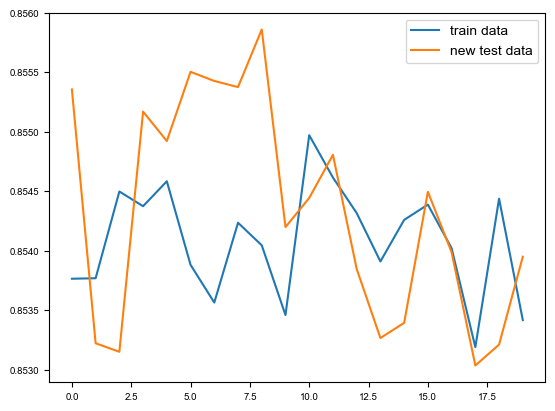

In [11]:
theoretical_errors = np.empty([10, 20])
theoretical_errors2 = np.empty([20])

for i, (train, test, rtrbm, rbm) in enumerate(zip(train_list, test_list, rtrbm_list, rbm_list)):
    v_data = train.detach().clone()
    
    for t in range(20):
        p_positive = torch.mean(v_data[:, t], axis=(1)) # mean firing rate per neuron
        theoretical_errors[i, t] = torch.mean(2*p_positive*(1 - p_positive)) # MSE of mismatch for binary signal
        

for t in range(20):
    p_positive = torch.mean(test_data[:, t], axis=(1)) # mean firing rate per neuron
    theoretical_errors2[t] = torch.mean(2*p_positive*(1 - p_positive)) # MSE of mismatch for binary signal
    
plt.plot(1 - np.mean(theoretical_errors, axis=0), label='train data')
plt.plot(1 - theoretical_errors2, label='new test data')
plt.legend()
plt.show()

Test error

In [36]:
n_steps = 10
acc_rbm, acc_rtrbm = torch.zeros(n_runs, n_steps), torch.zeros(n_runs, n_steps)

for i, (rtrbm, rbm) in enumerate(zip(tqdm(rtrbm_list), rbm_list)):
    # generate data
    vs_rtrbm, hs_rtrbm = rtrbm.sample(test_data[:, 0, :].to(rtrbm.device), chain=n_steps, pre_gibbs_k=400, gibbs_k=1, disable_tqdm=True, mode=1)
    vs_rbm, _ = rbm.sample(test_data[:, 0, :].to(rbm.device), chain=n_steps + 1, pre_gibbs_k=400, gibbs_k=1, disable_tqdm=True, mode=1)
    vt = test_data.detach().clone()

    # reshape
    vs_rbm = reshape(vs_rbm, T=n_steps+1, n_batches=test_data.shape[2])
    vs_rbm = vs_rbm[:, 1:, :]
    vt = vt[:, 1:, :] # 1: because in the sample function the RTRBM returns the sampled array without the first time step

    # calculate accuracy over timesteps
    acc_rbm[i] = torch.sum(vs_rbm[:, :n_steps, :].cpu() == vt[:, :n_steps, :].cpu(), axis=(0, 2)) / vt[:, 0].numel()
    acc_rtrbm[i] = torch.sum(vs_rtrbm[:, :n_steps, :].cpu() == vt[:, :n_steps, :].cpu(), axis=(0, 2)) / vt[:, 0].numel()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.68s/it]


C:\Users\Kasper\AppData\Local\Temp\ipykernel_9660\3139512675.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks()*100)


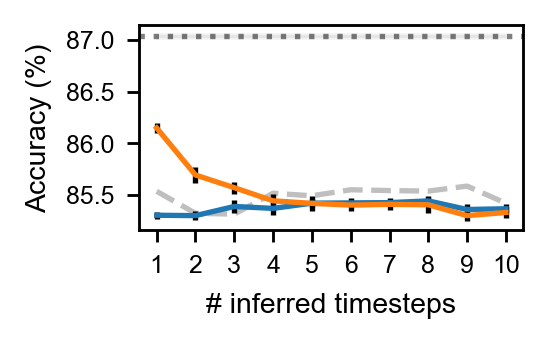

In [55]:
fig, ax = plt.subplots(facecolor='white', figsize=(2, 1.2), dpi=256)
t = np.arange(1, n_steps+1, 1)
t1 = np.arange(1, test.shape[1], 2)
ax.errorbar(t, torch.mean(acc_rbm, 0), torch.std(acc_rbm, 0), label='RBM', ecolor='k')
ax.errorbar(t, torch.mean(acc_rtrbm, 0), torch.std(acc_rtrbm, 0), label='RTRBM', ecolor='k')


mean_upper_acc = 0.8703444194
err_upper_acc = 0.0001690404 # = SEM = std(MSE) / sqrt(N)

# Lower bound (naive estimator)
#ax.axhline(1 - torch.mean(theoretical_MSE), c='k', alpha=0.25, linestyle='--', zorder=-1)
ax.plot(t, theoretical_accuracy[:n_steps], c='k', alpha=0.25, linestyle='--', zorder=-1)

# Upper bound due to variance in sampling when generating data
ax.axhline(mean_upper_acc, c='k', alpha=0.5, linestyle='dotted', zorder=-1)

ax.fill_between([1, n_steps], [mean_upper_acc - err_upper_acc]*2, [mean_upper_acc + err_upper_acc]*2,
               color = 'k', alpha=0.05, zorder=-2)

#ax.axvline(last_significant_timestep, color='k', ls=':', marker='.')
ax.set_xlabel('# inferred timesteps', fontsize=8)
ax.set_xticks(t)
ax.set_xticklabels(t, fontsize=7)
#ax.set_xlim([1, n_steps])
ax.set_ylabel('Accuracy (%)', fontsize=8)
#ax.set_ylim([0.855, 0.875])
ax.set_yticklabels(ax.get_yticks()*100)
plt.tight_layout(pad=0.2, h_pad=0, w_pad=0.2)

#plt.savefig(path2dir + '/images/figure2/accuracy.png', dpi=1000, transparent=True)
plt.show()

Now for statistical analysis: Display the MSE of both models as a function of time steps of prediction with their corresponding colors and SEMs around the curves.
For statistical testing, compare the two datasets by using a 2-way ANOVA, with factors timestep and model type. Both will likely be significant.

The last question would then be, up to which time-step do they stay significantly different. For this we will do do post-hoc testing, but also correct the p-values using Bonferroni correlation, i.e. multiply the p-value by the number of tests (i.e. # time-steps), and check up to which time point they stay significantly different. the p-value for each time point is computed by 2 group t-tests.

# Upper bound estimation

In [38]:
# Modified version of data generation algorithm, that is used to find many instances of
# of the background (= population without interaction) waves applied to known population states.

class PoissonTimeShiftedDataModified(PoissonTimeShiftedData):
    def __init__(
            self, lambda_init, neurons_per_population=10, n_populations=20, n_batches=200, time_steps_per_batch=100,
             delay=1, U=None, norm=1, **kwargs):

        """
        """
        if 'int_range' not in kwargs:  # Interval Range External Input
            kwargs['int_range'] = [5, 10]
        if 'ex_fr_range' not in kwargs:  # lower and upper bound of firing rate of external input
            kwargs['ex_fr_range'] = [0, 1.5]
        if 'std_range' not in kwargs:  # width of gaussian shaped peaks
            kwargs['std_range'] = [1, 2]
        if 'bound_fr_range' not in kwargs:  # lower and upper bound of firing rate after modulation
            kwargs['bound_fr_range'] = 3 * np.array(kwargs['ex_fr_range'])
        if 'spread_fr' not in kwargs: # firing rate spread inside one hidden population
            kwargs['spread_fr'] = [0.6, 1.4]

        self.kwargs = kwargs
            
        # If U is not given, create U with sequential firing of populations
        if U is None:
            U = create_U_hat(n_populations)
            U /= norm

        self.data = torch.empty(
            neurons_per_population * n_populations,
            time_steps_per_batch,
            n_batches,
            dtype=torch.float
        )

        population_waves = torch.zeros(n_populations, time_steps_per_batch + 1, n_batches)
        neuron_waves_interact = torch.zeros(neurons_per_population * n_populations, time_steps_per_batch, n_batches)
        idx = [torch.randperm(neurons_per_population) for _ in range(n_populations)]


        # get all mother trains by looping over populations
        for h in tqdm(range(n_populations)):
            background_wave = self.get_random_peaks(
                time_steps_per_batch=time_steps_per_batch + 1, n_batches=n_batches,
                n=10, **kwargs)

            population_waves[h, :, :] = self.get_random_peaks(
                time_steps_per_batch=time_steps_per_batch + 1, n_batches=n_batches,
                **kwargs) + background_wave

            
        # Set initial lambda / population waves
        population_waves[:, 0, :] = lambda_init.detach().clone()
            
        self.population_waves_original = population_waves.detach().clone()

        # compute interactions of all populations on their resulting firing rate
        for t in range(1, time_steps_per_batch + 1):
            for h in range(n_populations):
                population_waves[h, t, :] += torch.sum(
                    U[:, h][None, :, None] * population_waves[:, 0, :], (0, 1)
                ) / n_populations

            # constrain to only positive values, lower & upper limit and remove nan
            population_waves[:, t, :] = self.constraints(population_waves[:, t, :], **kwargs)

        # skip first step as it contains the initial condition
        population_waves = population_waves[:, 1:, :]

        
        for h in range(n_populations):
            neuron_waves_interact[neurons_per_population * h: neurons_per_population * (h + 1), ...] = \
                (population_waves[h, ...]).repeat(neurons_per_population, 1, 1) * \
                torch.linspace(kwargs['spread_fr'][0], kwargs['spread_fr'][1], neurons_per_population)[idx[h], None, None]

        self.data = torch.poisson(neuron_waves_interact)

        # make sure there are
        self.data[self.data < 0] = 0
        self.data[self.data > 1] = 1
        self.population_waves_interact = population_waves
        self.neuron_waves_interact = neuron_waves_interact
        self.firing_rates = torch.mean(self.data, (1, 2))
        self.delay = delay
        self.time_steps_per_batch = time_steps_per_batch
        self.U = U
        
def reshape_fortran(x, shape):
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))

In [51]:
torch.random.manual_seed(0)
np.random.seed(0)

# SIMULATION PLAN:
# Every batch has their own l_init = starting population wave, which is sampled from the distribution
# of all population waves. Then, for every time step, the population wave is exactly as if the
# previous time step was the initial population wave.

# Doing this gives an estimate of the variance in population waves due to the background/original
# population waves.
# This is repeated for many batches with different starting states to yield a representative average
# of the possible states.


# Sample population states directly from true distribution of population waves

T = 100*1000
waves = reshape_fortran(s_test.population_waves_interact[:, 25:], shape=[n_h, T])

n_batches = 10000 # number of initial waves to use
# NOTE: This many batches takes quite some time to simulate
time_steps_per_batch = 125 # number of background samples per initial wave


# Sadly, due to weird behaviour from the code, the number of time steps
# per batch should match that in the test and train data, as the mean firing
# rate is affected by the number of time steps...
# This means that in this case even if a lower number would suffice (and it would
# run much faster) it is not possible to do so.
# At the same time, the number of batches should be high as this is by far the
# largest source of the variability in the estimate, as this corresponds to
# different intial waves.

selected_waves = np.random.choice(np.arange(T), size=n_batches, replace=False)

l_init = waves[:, selected_waves]

print("Generating interactions..")
s_modified = PoissonTimeShiftedDataModified(l_init,
    neurons_per_population=neurons_per_population,
    n_populations=n_h, n_batches=n_batches,
    time_steps_per_batch=time_steps_per_batch,
    delay=delay, U=U_hat.T,
    int_range=int_range, fr_range=fr_range, std_range=std_range)

# Calculate MSE for each batch. The mean of these is an estimate of the lower bound on the
# MSE for a model with perfect knowledge of the underlying population waves from previous
# timesteps.

ACC = np.empty([n_batches])

print("Calculating accuracy...")
halfwaypoint = time_steps_per_batch // 2
for batch in tqdm(range(n_batches)):
    e1 = torch.exp(-s_modified.neuron_waves_interact[:, :halfwaypoint, batch])
    e2 = torch.exp(-s_modified.neuron_waves_interact[:, -halfwaypoint:, batch])
    
    # The idea is that data1 and data2 have different background waves for identical population wave states,
    # such that the MSE between the two corresponds to a model with perfect knowledge of the previous population state.
    
    # Sampling data1 (data2) from the first (second) half of the waves is a computationally efficient trick for
    # choosing two different background waves.
    # Another solution would be to repeatedly randomly select two unique waves and compare them.
    
    ACC[batch] = 1 - torch.mean(e1 + e2 - 2*e1*e2) # Theoretical mean accuracy (numerically verified)

print("Accuracy upper bound = {:.10f} +- {:.10f}".format(np.mean(ACC), np.std(ACC) / np.sqrt(n_batches)))

Generating interactions..


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.71s/it]


Calculating accuracy...


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2415.07it/s]

Accuracy upper bound = 0.8703444194 +- 0.0001690404


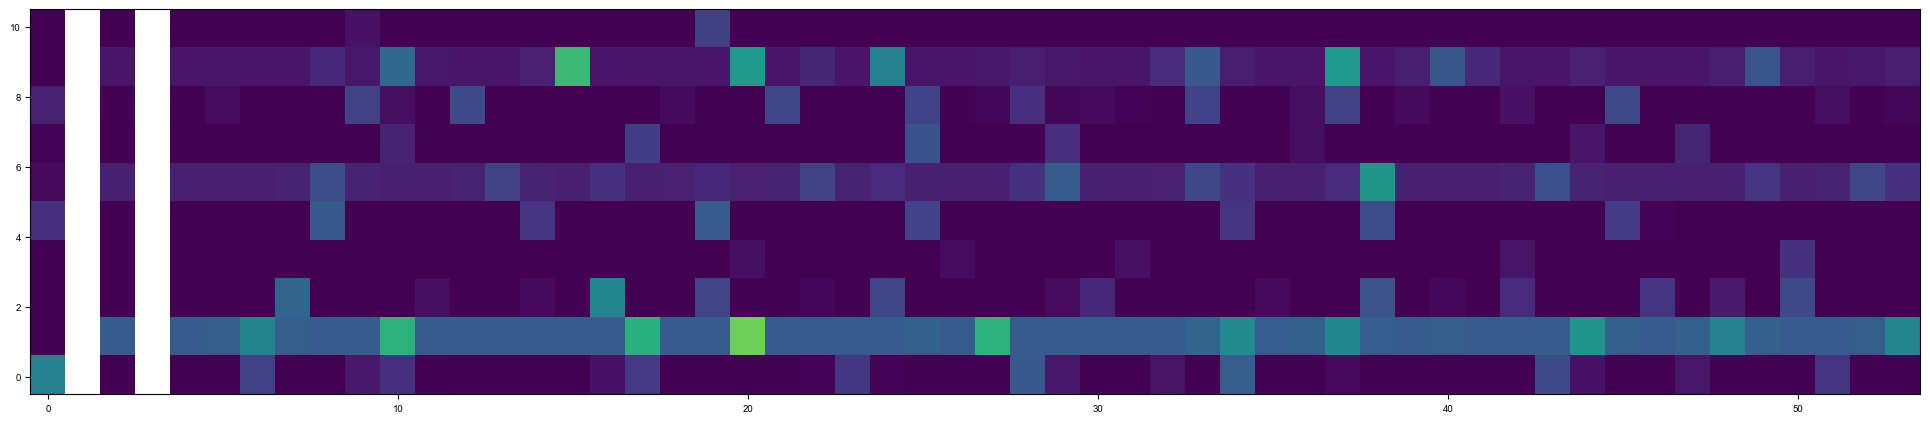

In [106]:
# Show result of simulation
# this shows in the first column the starting state (lambda(t-1)),
# followed by a column for the expected state after interactions (lambda(t)) without intrinsic waves,
# and then many sampled instances of this state with the intrinsic waves.

n_show = 50
extent = np.array([3.5, n_show + 3.5, -0.5, n_h + 0.5])
extent2 = np.array([-0.5, 0.5, -0.5, n_h + 0.5])

batch = 4
l_interact = torch.zeros_like(l_init[:, batch])

for h in range(n_h):
    l_interact[h] = torch.sum(U_hat.T[:, h] * l_init[:, batch]) / n_h
    
l_interact = s_modified.constraints(l_interact, **s_modified.kwargs)

plt.figure(figsize = (n_show/2, 5))

# Show initial state and interacted state without background activity
plt.imshow(np.array([l_init[:, batch].numpy()]).T, extent=extent2, vmin=0, vmax=1)
plt.imshow(np.array([l_interact.numpy()]).T, extent=extent2 + [2, 2, 0, 0], vmin=0, vmax=1)

# Show some instances with background activity
plt.imshow(s_modified.population_waves_interact[:, 1:n_show+1, batch], extent=extent, vmin=0, vmax=1)

plt.xlim([extent2[0], extent[1]])
plt.show()

In [107]:
# Calculate MSE for each batch. The mean of these is an estimate of the lower bound on the
# MSE for a model with perfect knowledge of the underlying population waves from previous
# timesteps.

torch.random.manual_seed(2)
np.random.seed(2)

MSE = np.empty([n_batches])

for batch in tqdm(range(n_batches)):
    data1 = torch.poisson(s_modified.neuron_waves_interact[..., batch])
    data2 = torch.poisson(s_modified.neuron_waves_interact[..., batch].flip(1)) # sample with waves in reverse order
    
    # The idea is that data1 and data2 have different background waves for identical population wave states,
    # such that the MSE between the two corresponds to a model with perfect knowledge of the previous population state.
    
    # Sampling data2 from the waves in reverse order is a computationally efficient trick for
    # choosing two different background waves, where in this case each computation is calculated twice.
    # Another solution would be to repeatedly randomly select two unique waves and compare them.

    data1[data1 > 1] = 1
    data2[data2 > 1] = 1

    MSE[batch] = torch.sum(torch.abs(data1 - data2)).cpu() / data1.numel()
    # = var(data1 - data2) = (on average) 2*var(data1)
    
print("MSE lower bound = {:.10f} +- {:.10f}".format(np.mean(MSE), np.std(MSE) / np.sqrt(n_batches)))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:09<00:00, 144.86it/s]

MSE lower bound = 0.1298252960 +- 0.0001712437


               df    sum_sq   mean_sq          F        PR(>F)
model_type    1.0  0.000089  0.000089  31.195894  7.674061e-08
timestep      1.0  0.000207  0.000207  72.597896  4.098884e-15
Residual    197.0  0.000561  0.000003        NaN           NaN
the RTRBM significantly outperforms RBM until timestep 4


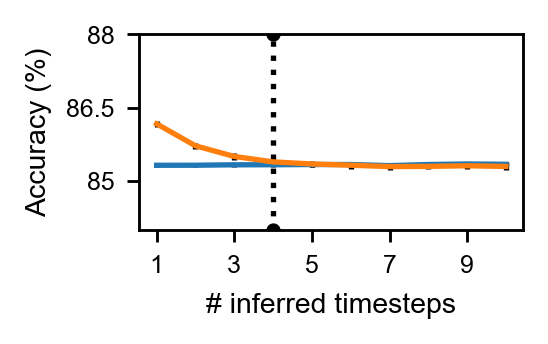

In [208]:
# Importing libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols

n_timesteps = n_steps + 1

df = pd.DataFrame({
    'timestep': np.tile(np.arange(1, n_timesteps), 2*n_runs),
    'model_type': np.concatenate((np.repeat('rbm', (n_timesteps-1)*n_runs), np.repeat('rtrbm', (n_timesteps-1)*n_runs))),
    'value': np.concatenate((mse_rbm.flatten(), mse_rtrbm.flatten()))
})

# Performing two-way ANOVA
model = ols('value ~ timestep + model_type', data=df).fit()
result = sm.stats.anova_lm(model, type=2)

print(result)

# Perform post-hoc tests with Bonferroni correction
p_values = []
timesteps = np.arange(1, n_timesteps)
for i in timesteps:
    ttest = ttest_ind(mse_rbm[:, i-1], mse_rtrbm[:, i-1])
    p_values += [ttest.pvalue * i] # the *i is the Bonferroni correction

last_significant_timestep = np.min(timesteps[np.array(p_values) > .05])

print("the RTRBM significantly outperforms RBM until timestep %i" %last_significant_timestep)

# plot the figure
fig, ax = plt.subplots(facecolor='white', figsize=(2, 1.2), dpi=256)
t = np.arange(1, n_timesteps, 1)
t1 = np.arange(1, n_timesteps, 2)
ax.errorbar(t, 1 - torch.mean(mse_rbm, 0), torch.std(mse_rbm, 0), label='RBM', ecolor='k')
ax.errorbar(t, 1 - torch.mean(mse_rtrbm, 0), torch.std(mse_rtrbm, 0), label='RTRBM', ecolor='k')
ax.axvline(last_significant_timestep, color='k', ls=':', marker='.')
ax.set_xlabel('# inferred timesteps', fontsize=8)
ax.set_xticks(t1)
ax.set_xticklabels(t1, fontsize=7)
ax.set_ylabel('Accuracy (%)', fontsize=8)
ax.set_ylim([0.84, 0.88])
ax.set_yticks([0.85, 0.865, 0.88])
ax.set_yticklabels([85, 86.5, 88], fontsize=7)
plt.tight_layout(pad=0.2, h_pad=0, w_pad=0.2)
# plt.savefig(path2dir + '/figures/figure2_poisson/MSE_RBM_RTRBM.png', dpi=1000, facecolor=fig.get_facecolor())

Both model_type and timestep have p-value <0.05 in the 2-way ANOVA test, so these are indeed significant.

In [206]:
# Importing libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols

n_timesteps = n_steps + 1

df = pd.DataFrame({
    'timestep': np.tile(np.arange(1, n_timesteps), 2*n_runs),
    'model_type': np.concatenate((np.repeat('rbm', (n_timesteps-1)*n_runs), np.repeat('rtrbm', (n_timesteps-1)*n_runs))),
    'value': np.concatenate((mse_rbm.flatten(), mse_rtrbm.flatten()))
})

# Performing two-way ANOVA
model = ols('value ~ timestep + model_type', data=df).fit()
result = sm.stats.anova_lm(model, type=2)

print(result)

# Perform post-hoc tests with Bonferroni correction
p_values = []
timesteps = np.arange(1, n_timesteps)
for i in timesteps:
    ttest = ttest_ind(mse_rbm[:, i-1], mse_rtrbm[:, i-1])
    p_values += [ttest.pvalue * i] # the *i is the Bonferroni correction

last_significant_timestep = np.min(timesteps[np.array(p_values) > .05])

print("the RTRBM significantly outperforms RBM until timestep %i" %last_significant_timestep)

               df    sum_sq   mean_sq          F        PR(>F)
model_type    1.0  0.000089  0.000089  31.195894  7.674061e-08
timestep      1.0  0.000207  0.000207  72.597896  4.098884e-15
Residual    197.0  0.000561  0.000003        NaN           NaN
the RTRBM significantly outperforms RBM until timestep 4


# Show test data

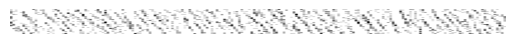

In [99]:
data = reshape_fortran(test_data[..., :10], (test_data.shape[0], 10*test_data.shape[1])) # batch clearly showing 

n_show = 200

plt.imshow(data[:, :n_show], cmap='binary', interpolation='antialiased', aspect = (10/(neurons_per_population*n_h)), vmax=0.75)
    
#     plt.gca().set_yticks([])
#     plt.gca().set_xticks([])
plt.gca().axis('off')
plt.show()

In [100]:
# separate images
from PIL import Image

n_v = n_h*neurons_per_population
n_ds = 10
n_show = 20 # single batch
offset = 40

output_path = 'images/figure2/'

img = Image.fromarray(255 * np.array(1 - data[:, offset:offset+n_show]).astype('uint8'), mode='L')
img = img.resize((100*img.size[0], 10*img.size[1]), Image.Resampling.NEAREST)
#img.save(output_path + 'test_data_batch.png')

## Temporal cross correlation

Max strength = 0.105
Offset strength = 5.25%


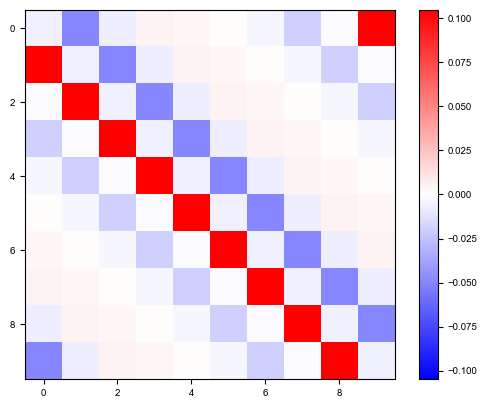

In [153]:
# temporal cross correlation
#data = rtrbm.V
data = s.data


corrs = np.empty(n_h)

for i in range(n_h):
    corrs[i] = np.corrcoef(data[:, :-1].flatten(), np.roll(data[:, 1:], neurons_per_population*i, axis=0).flatten())[0, 1]

U_mean = np.empty([n_h, n_h])
for i in range(n_h):
    U_mean[i] = np.roll(corrs, i)

lim = np.max(np.abs(corrs))

print("Max strength = {:.3f}".format(np.max(U_mean)))
print("Offset strength = {:.2f}%".format(100 * U_mean[0, 3] / np.max(U_mean)))

plt.imshow(U_mean, cmap='bwr', vmin=-lim, vmax=lim)
plt.colorbar()
plt.show()